In [1]:
#import libraries and dependancies
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
#/home/jasleen/Cis520_RLFinalProject/data_state_action_RL.csv

# Import the state and action pairs generated by following a random policy
data = np.genfromtxt('data_state_action_RL.csv',delimiter=',',dtype=None)

In [3]:
#print(data.shape)

In [4]:
# Store the State and Action Data separately for clustering
state_space_data = data[:,:376]
action_space_data= data[:,376:]

In [5]:
#create environment
env = gym.make('Humanoid-v2')

In [6]:
# print(state_space.shape)
# print(action_space.shape)

In [7]:
#Our model parameters
total_episodes = 500
K = 10
#Learning rate
alpha = 0.1
#Discount rate
gamma = 0.95
#Exploration proportion
epsilon = 0.05
# Number of clusters of state
num_clusters_s = 100
#Number of clusters of action
num_clusters_a = 10

#Max iteration -- required?
max_iter = 300
n_runs = 10
# ny = 4
# nx = 12
n_actions = env.action_space.shape[0]

In [8]:
#process the state/action space, run clustering algorithm on it and 
#return the k_means model fitted on the input states
def process_state(s, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, init='random',max_iter=max_iter, tol=1e-04, random_state=0)
    k_means_state= kmeans.fit(s)
    return k_means_state


In [9]:
#create a dictionary containing correspondence between cluster centers 
#for state/action and index given k_means model and the input states
def create_state_dict(k_means_state, num_clusters):
    dict = {}
    #state_cluster_pred = k_means_state.predict(s)-----------? delete
    #idx = s.shape[0]
    
    print('index -- state dict', num_clusters)
    
    for i in range(num_clusters):
        dict[i]= k_means_state.cluster_centers_[i]
    return dict
    

In [10]:
#processing the initial data obtained from random sampling and clustering it
states_k_means = process_state(state_space_data,num_clusters_s)
action_k_means = process_state(action_space_data,num_clusters_a)

In [11]:
# creating dictionaries with 1:1 correpondence between idx and cluster center
clustered_state_dict = create_state_dict(states_k_means,  num_clusters_s)
clustered_action_dict = create_state_dict(action_k_means,  num_clusters_a)

index -- state dict 100
index -- state dict 10


In [12]:
# Q-learning (off-policy TD learning) with epsilon greedy
def policy_learnt(Q, state,state_idx, env, epsilon):
  if np.random.random() < epsilon:
    action_1 = env.action_space.sample()
    action_1 = action_1.astype(float)
    action_idx = action_k_means.predict(action_1.reshape(1,-1))
    action_idx = tuple(action_idx)[0]
    return action_idx # return a random action
  else:
    return np.argmax(Q[state_idx, :]) # return the action which 
                                # gives the maximum reward for an action

In [13]:
# def create_reduced_table(state_k_means, action_k_means, num_clus_s, num_clus_a, state_space):
#     state_trans_table = np.array((num_clus_s, num_clus_a))
#     state_trans_table = np.array((num_clus_s, num_clus_a))
#     for i in range 
    

In [14]:
# def process_action(a):
#     kmeans = KMeans(n_clusters=num_clusters_a, init='random',n_init=n_runs, max_iter=max_iter, tol=1e-04, random_state=0)
#     k_means_action= kmeans.fit_predict(a)
#     return k_means_action


In [15]:
def train(env, policy, total_episodes = 5, run_test = False, test_freq = 10):
  
  # Set the agent at starting position
  state = env.reset()
#   print('s',state)
  # process the current state to a cluster state
  state_idx = states_k_means.predict(state.reshape(1,-1)) #index of the predicted cluster
#   print('stae', state_idx)
  state = clustered_state_dict[tuple(state_idx)[0]] #the center of the predicted cluster --processed state

  # Initialize Q values as 0-- the size of Q depends on the number of cluster
  Q = np.zeros((num_clusters_s, num_clusters_a))
  cumulative_reward = 0
  n_episodes = 0
  episode_rewards = []
  test_rewards = []
  env.render()
  # Here an episode only ends once we reach the goal location. 
  # So we're training for 500 successful episodes' worth of experience.
  while n_episodes < total_episodes:
 
    #find action given by policy for this state
    action_idx = policy_learnt(Q,state,state_idx, env, epsilon)
#     print('act',action_idx.tolist())
#     print(type(action_idx))
    action = clustered_action_dict[action_idx]
#     print('action', action)
    
    prev_state = state
    prev_state_idx = state_idx
    
    # Step the environment forward
    state, reward, done, info = env.step(action)
    
    # convert discrete (-0.2, 0.2) to continous space with same values
#     action = reverse_process_action(action)
#     s, reward, done, _ = env.step(action)
    
    state_idx = states_k_means.predict(state.reshape(1,-1)) #index of the next predicted cluster
    state = clustered_state_dict[tuple(state_idx)[0]] #the center of the predicted cluster -- processed state
    
#     s = process_state(s)
    
        
    # Now we have our current state, action, next state and reward
    # So we can take our updates
    future_reward = reward + gamma*np.max(Q[state_idx, :])
    expected_future_reward = Q[prev_state_idx, action_idx]
    Q[state_idx, action_idx] += alpha*(future_reward-expected_future_reward)
    cumulative_reward += reward
    # Reset the agent if we're done. Track rewards
    if done:
      if run_test and n_episodes%test_freq == 0:
        test_r = test(env, on_policy, Q)
        test_rewards.append([n_episodes, test_r])
      s = env.reset()
      episode_rewards.append(cumulative_reward)
      n_episodes += 1
      cumulative_reward = 0

  return episode_rewards, Q

In [16]:
qlearning_rewards = np.zeros((K, total_episodes))
qpolicy = lambda q,s: policy_learnt(q, s, s_idx, env, epsilon)

for idx in range(K):
  # Train with Q-learning
  rewards, Q_q = train(env, qpolicy, total_episodes)
  qlearning_rewards[idx,:] = rewards

Creating window glfw


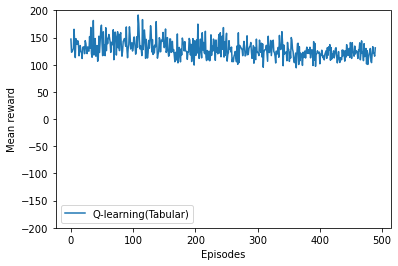

In [19]:
plt.plot(np.mean(qlearning_rewards[:,10:], 0).T)
plt.legend(['Q-learning(Tabular)'])
plt.xlabel('Episodes')
plt.ylabel('Mean reward');
plt.ylim([-200,200]);

In [18]:
env.close()

In [121]:
%debug

> /tmp/ipykernel_31839/3786122601.py(25)train()
     23     print('act',action_idx.tolist())
     24 #     print(type(action_idx))
---> 25     action = clustered_action_dict[action_idx]
     26     print('action', action)
     27 

ipdb> action_idx
array([-0.07411446,  0.3039725 , -0.2820038 ,  0.21176326,  0.07476222,
        0.03815548, -0.221687  , -0.12788054,  0.23818101, -0.27068833,
        0.08526447,  0.22115287,  0.25707576, -0.38977748,  0.28526035,
       -0.20191523, -0.25697577], dtype=float32)
ipdb> quit
